# Classificação de Imagens de 38 classes de plantas e tipos de doenças, com Transfer Learning
#### Objetivo: Analisar algumas redes com transfer learning e comparar os resultados, com base na variação de ajustes relacionados a parâmetros de early stop, early rate, camada dropout, camada BatchNormalize e Batchsize.
#### Após análises dos dados de cada uma das 38 classes de imagens e por questão de performance, na execução limitada de processamento, a opção foi por utilizar somente 04 classes de status das condições de folhas de Uva, sendo que uma delas não continha imangens, sendo assim essa descartada.


##### Classes Consideradas:
###### Grape___Black_rot
###### Grape___Esca_(Black_Measles)
###### Grape___healthy

## Legenda:
#### Localização da base de dados no Kaggle: https://www.kaggle.com/datasets/vipoooool/new-plant-diseases-dataset
#### Base de dados de treino (trainpath): Já separada pelo autor da base de dados, em localização específica no Kaggle.
#### base de dados de validação (validpath): Já separada pelo autor da base de dados, em localização específica no Kaggle. 
## Consultas:
##### https://keras.io/applications/
##### https://keras.io/api/applications/vgg/
##### https://www.tensorflow.org/tutorials/load_data/images
##### https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory
##### https://keras.io/api/data_loading/

## Leitura do local da base de dados

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import os
workdir_path = '/content/drive/MyDrive/TrabalhoFinal/DadosTCC/archive' #MODIFICAR!!! #Caminho para o seu workspace
os.chdir(workdir_path)

Mounted at /content/drive


In [2]:
os.path.abspath(os.getcwd())

'/content/drive/.shortcut-targets-by-id/1l60AC27n8nkWWiKY_Crqb8SeOohho5uQ/TrabalhoFinal/DadosTCC/archive'

In [3]:
# Base de imagens para treino com total de xx imagens (classes de tipos de platas)
trainpath = workdir_path + '/classeuva/Train'

# Base de imagens para validação com total de xx imagens (classes de tipos de platas)
validpath = workdir_path + '/classeuva/Valid'

# Base de imagens para testes com total de xx imagens (classes de tipos de platas)
testpath = workdir_path + '/classeuva/Test'

## Leitura de Bibliotecas

In [4]:
!pip install keras_tqdm
import numpy as np
import keras as ks
import tensorflow as tf
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import preprocess_input, decode_predictions
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import *
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Sequential, Model,load_model
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.optimizers import SGD
import os
import tensorflow_datasets as tfds
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from PIL import Image
# from keras.preprocessing.image import array_to_img, img_to_array, load_img
# from keras.applications.vgg16 import preprocess_input
from keras import losses
from tensorflow.keras.optimizers import RMSprop
from keras_tqdm import TQDMNotebookCallback
from random import randint
import matplotlib.pylab as plt




Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Contagem das classes de treino

In [5]:
# Contar as imagens em cada pasta. Uma pasta = uma classe de planta

count=0
nomeplantas=[]
totalimagens=[]
for i in os.listdir(trainpath):
  count+=1
  nomeplantas.append(i)
  
  images_path=os.listdir(trainpath+"/"+i)
  totalimagens.append(len(images_path))


In [6]:
# Total de Classes de Plantas
len(nomeplantas)

3

## Contagem das classes de validação

In [7]:
# Contar as imagens em cada pasta. Uma pasta = uma classe de planta

count=0
nomeplantas=[]
totalimagens=[]
for i in os.listdir(validpath):
  count+=1
  nomeplantas.append(i)
  
  images_path=os.listdir(validpath+"/"+i)
  totalimagens.append(len(images_path))


In [8]:
# Total de Classes de Plantas
len(nomeplantas)

3

## Tratar e  Carregar a Base de Treino
##### Ref: Como carregar imagens no Keras:
https://www.tensorflow.org/tutorials/load_data/images
##### A documentação da função que usa para carregar os dados (detalhes dos parâmetros):
https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory

In [9]:
# A carga da imagem é feita em lotes o tamanho de lote ("batch_size") de 32 imagens
batch_size = 32
# altura da imagem
img_height = 224
# largura da imagem
img_width = 224

In [10]:
# usar a função para carregar as imagens:
# https://www.tensorflow.org/tutorials/load_data/images
# https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory

train_data = tf.keras.utils.image_dataset_from_directory(   # função para carregar imagens de treino
  trainpath,                                                # caminho onde estão as imagens de treino (diretório "raiz")
  labels='inferred',                                        
  label_mode='categorical',                                          
  image_size=(img_height, img_width),                       # largura e altura
  batch_size=batch_size)                                    # tamanho do lote


Found 4659 files belonging to 3 classes.


In [11]:
# verifica o nome das classes (são 38 pastas, cada pasta é uma classe)
train_data.class_names

['Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___healthy']

In [12]:
# visualizar o tipo de objeto retornado
train_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

In [13]:
# loop para ver a dimensão da imagem:
# 32 classes (pastas)
# 250 largura
# 250 altura
# 3 canais
# obs: Um break para evitar de percorrer todas as imagens
for image_batch, labels_batch in train_data:
  print(image_batch.shape)
  break

(32, 224, 224, 3)


In [14]:
# Normalizar as imagens de treino para estabelecer uma variação de valores entre [0..1]. Camada específica para isso.
# Fonte: Documentação Keras

normalization_layer = tf.keras.layers.Rescaling(1./255)
train_data_normalized = train_data.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(train_data_normalized))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


0.059463095 0.94505787


In [15]:
# Analisa o resultado da normalização da Base de Treino
for image_batch, labels_batch in train_data_normalized:
  print(image_batch.shape)
  break

(32, 224, 224, 3)


In [16]:
# Analisa o resultado da normalização da Base de Treino - Formato
train_data_normalized

<MapDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

In [17]:
# Analisa o resultado da normalização da Base de Treino - Matriz EGB
image_batch[5]

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[0.52192885, 0.49839938, 0.5062426 ],
        [0.55780315, 0.53427374, 0.5421169 ],
        [0.5766507 , 0.55312127, 0.5609644 ],
        ...,
        [0.50936455, 0.48583516, 0.4936783 ],
        [0.45502135, 0.43149194, 0.43933508],
        [0.539958  , 0.5164286 , 0.5242717 ]],

       [[0.55160064, 0.5280712 , 0.53591436],
        [0.5390156 , 0.5154862 , 0.5233293 ],
        [0.52270913, 0.4991797 , 0.50702286],
        ...,
        [0.48677528, 0.46324584, 0.471089  ],
        [0.4569424 , 0.433413  , 0.44125614],
        [0.5560846 , 0.53255516, 0.5403983 ]],

       [[0.52350944, 0.49998003, 0.50782317],
        [0.52016807, 0.49663866, 0.5044818 ],
        [0.49581835, 0.47228897, 0.4801321 ],
        ...,
        [0.50650287, 0.4829734 , 0.49081653],
        [0.46132416, 0.43779472, 0.44563788],
        [0.48401433, 0.46048492, 0.46832806]],

       ...,

       [[0.7605842 , 0.75274104, 0.7566626 ],
        [0.75

## Tratar e  Carregar a Base de Validação
## Ref: Como carregar imagens no Keras:
https://www.tensorflow.org/tutorials/load_data/images
## A documentação da função que usa para carregar os dados (detalhes dos parâmetros):
https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory

In [18]:
# A carga da imagem é feita em lotes o tamanho de lote ("batch_size") de 32 imagens
batch_size = 32
# altura da imagem
img_height = 224
# largura da imagem
img_width = 224

In [19]:
trainpath

'/content/drive/MyDrive/TrabalhoFinal/DadosTCC/archive/classeuva/Train'

In [20]:
testpath

'/content/drive/MyDrive/TrabalhoFinal/DadosTCC/archive/classeuva/Test'

In [21]:
validpath

'/content/drive/MyDrive/TrabalhoFinal/DadosTCC/archive/classeuva/Valid'

In [22]:
# usar a função para carregar as imagens:
# https://www.tensorflow.org/tutorials/load_data/images
# https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory

valid_data = tf.keras.utils.image_dataset_from_directory(   # função para carregar imagens de validação
  validpath,                                                # caminho onde estão as imagens de vaçidção (diretório "raiz")
  labels='inferred',                                        
  label_mode='categorical',                                 
  image_size=(img_height, img_width),                       # largura e altura
  batch_size=batch_size)                                    # tamanho do lote

Found 1169 files belonging to 3 classes.


In [23]:
# verifica o nome das classes (são 38 pastas, cada pasta é uma classe)
valid_data.class_names

['Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___healthy']

In [24]:
# visualizar o tipo de objeto retornado
valid_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

In [25]:
# loop para ver a dimensão da imagem:
# 32 classes (pastas)
# 250 largura
# 250 altura
# 3 canais
# obs: Um break para evitar de percorrer todas as imagens
for image_batch, labels_batch in valid_data:
  print(image_batch.shape)
  break

(32, 224, 224, 3)


In [26]:
# Normalizar as imagens de validação para estabelecer uma variação de valores entre [0..1]. Camada específica para isso.
# Fonte: Documentação Keras

normalization_layer = tf.keras.layers.Rescaling(1./255)
valid_data_normalized = valid_data.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(valid_data_normalized))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))


0.0 0.9107261


In [27]:
# Analisa o resultado da normalização da Base de Validação
for image_batch, labels_batch in valid_data_normalized:
  print(image_batch.shape)
  break

(32, 224, 224, 3)


In [28]:
# Analisa o resultado da normalização da Base de Validação - Formato
valid_data_normalized

<MapDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

In [29]:
# Analisa o resultado da normalização da Base de Validação - Matriz EGB
image_batch[2]

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[0.06988797, 0.03877553, 0.03793519],
        [0.58515406, 0.5537815 , 0.5420168 ],
        [0.6509204 , 0.61954784, 0.60778314],
        ...,
        [0.73277307, 0.7131652 , 0.7014005 ],
        [0.7238095 , 0.70420164, 0.69243693],
        [0.7184873 , 0.6988795 , 0.6871148 ]],

       [[0.07062826, 0.04367749, 0.04283715],
        [0.64393765, 0.6125651 , 0.6008004 ],
        [0.6278912 , 0.59651864, 0.58475393],
        ...,
        [0.74257696, 0.7229691 , 0.7112044 ],
        [0.73427373, 0.7146659 , 0.7029012 ],
        [0.7283513 , 0.70874345, 0.69697875]],

       [[0.06646661, 0.04237697, 0.04153663],
        [0.6326932 , 0.6013206 , 0.5895559 ],
        [0.65598243, 0.6246099 , 0.6128452 ],
        ...,
        [0.755022  , 0.73541415, 0.72364944],
        [0.7501401 , 0.7305322 , 0.7187675 ],
        [0.74331725, 0.7237094 , 0.7119447 ]],

       ...,

       [[0.07042805, 0.05158059, 0.05474178],
        [0.72

## Resumo Leitura de Imagens
##### 4659 testes, 1169 validação

## Modelo de Classificação VGG19 sem Transfer Learning e Data Augmentation
##### Analisar a resposta da classificação

In [30]:
pip install tf-explain

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 KB 1.8 MB/s eta 0:00:00


In [31]:
## Código consultado em https://medium.com/analytics-vidhya/image-recognition-using-pre-trained-xception-model-in-5-steps-96ac858f4206

# from tensorflow.keras.applications.resnet50 import ResNet50
# from tensorflow.keras.preprocessing import image
# from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
# from tensorflow.keras.optmizers import Adam
# from tensorflow.keras.losses import CategoricalCrossentropy
# import numpy as np

model = tf.keras.applications.VGG19(weights='imagenet', input_shape=(img_height,img_width,3))

# Carrega uma imagem de uma classe (Treino) para verificar a predição nessa Rede, nessas condições.
img = image.load_img(trainpath+"/Grape___healthy/ac753212-e6d7-44b9-9722-4413a7418ab3___Mt.N.V_HL 6178_180deg.JPG", target_size=(img_height,img_width,3))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = model.predict(x)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
print('Predicted:', decode_predictions(preds, top=4)[0])


35363/35363 [==============================] - 0s 0us/step
Predicted: [('n03991062', 'pot', 0.2972955), ('n12768682', 'buckeye', 0.10490957), ('n04522168', 'vase', 0.08454256), ('n12267677', 'acorn', 0.04454502)]


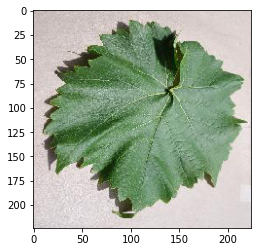

In [32]:
# Avaliação da assertividade para a classe Tomato___Tomato_mosaic_virus da base de treino
import matplotlib.pylab as plt
plt.imshow(img)

Modelo nessa condição não obteve sucesso na identificação de uma imagem de uma classe. O que era previsto somente comprovando a necessidade de treinar um modelo aplicando Transfer Learning.

In [33]:
# Visualização das Camadas do Modelo VGG19 sem Transfer Learning e Data Augmentation
model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## Analisa Camadas VGG19 Truncada

In [34]:
base_model_tf=tf.keras.applications.VGG19(weights='imagenet', classes=3, input_shape=(img_height,img_width,3), include_top=False)

#Model building
base_model_tf.trainable=False

base_model_tf.summary()


80134624/80134624 [==============================] - 0s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [35]:
## API Keras https://keras.io/guides/functional_api/
## https://keras.io/guides/sequential_model/

## Modelo VGG19 Base para Aplicar Transfer Learning


In [36]:
# Modelo Truncado:
modelo_base = tf.keras.applications.VGG19(weights='imagenet', classes=3, input_shape=(img_height,img_width,3), include_top=False)
# "Congelar" as camadas superiores (manter os pesos):
modelo_base.trainable=False
modelo_base.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## Modelo VGG19 Truncado + Camada Dense

*   Aproveitar a base de conhecimento VGG19 (Imagenet) e seus pesos
*   Treinar essa base adicionando as novas Classes de Treino das Imagens Coletadas



In [37]:
# from tensorflow.keras.layers import Flatten
sh=Input(shape=(img_height,img_width,3)) # Formato de entrada imagem
conv=tf.cast(sh,tf.float32) 

modelo_dense_1=modelo_base(conv,training=False) #
modelo_dense_1=GlobalAveragePooling2D()(modelo_dense_1)
modelo_dense_1=Dropout(0.2)(modelo_dense_1)
modelo_dense_1=ks.layers.BatchNormalization(axis=1, momentum=0.99, epsilon=0.001)(modelo_dense_1)
modelo_dense_1=Dense(128,activation='relu')(modelo_dense_1)
modelo_dense_1=Dense(64,activation='relu')(modelo_dense_1)
modelo_dense_1=Dense(3,activation='softmax')(modelo_dense_1)

from keras.models import Model
modelo_final_1=Model(inputs=sh,outputs=modelo_dense_1)
modelo_final_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.cast (TFOpLambda)        (None, 224, 224, 3)       0         
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                               

In [38]:
modelo_final_1.layers

In [39]:
# Definie as métricas
earlystp=EarlyStopping(patience=25, monitor='val_loss') # Evitar um Overfiting do Modelo
metrics = ['accuracy',Precision(),Recall(), AUC()]

In [40]:
# Compila o Modelo
modelo_final_1.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.01),metrics=metrics)

In [41]:
# Processa o modelo com Transfer Learning usando a base de imagens de Treino Normalizada e a base de Validação Normalizada
modelo_final_1_Hist = modelo_final_1.fit(train_data_normalized,validation_data=valid_data_normalized,epochs=200,verbose=1,callbacks=[earlystp])

Epoch 1/200
146/146 [==============================] - 497s 3s/step - loss: 0.2960 - accuracy: 0.8895 - precision: 0.8982 - recall: 0.8802 - auc: 0.9760 - val_loss: 0.5524 - val_accuracy: 0.7348 - val_precision: 0.7998 - val_recall: 0.6664 - val_auc: 0.9314
Epoch 2/200
146/146 [==============================] - 33s 217ms/step - loss: 0.2098 - accuracy: 0.9169 - precision: 0.9188 - recall: 0.9135 - auc: 0.9868 - val_loss: 0.3647 - val_accuracy: 0.7716 - val_precision: 0.7926 - val_recall: 0.7648 - val_auc: 0.9639
Epoch 3/200
146/146 [==============================] - 35s 233ms/step - loss: 0.1980 - accuracy: 0.9204 - precision: 0.9230 - recall: 0.9163 - auc: 0.9885 - val_loss: 0.1797 - val_accuracy: 0.9504 - val_precision: 0.9532 - val_recall: 0.9418 - val_auc: 0.9951
Epoch 4/200
146/146 [==============================] - 35s 235ms/step - loss: 0.1920 - accuracy: 0.9309 - precision: 0.9333 - recall: 0.9279 - auc: 0.9887 - val_loss: 0.1622 - val_accuracy: 0.9256 - val_precision: 0.9318 -

In [42]:
modelo_final_1.save('/content/drive/MyDrive/TrabalhoFinal/DadosTCC/archive/Inferência-TestesModelos/Caso de Teste 04/VGG19-cenário07/Modelo_Salvo_1/VGG19.h5')

In [43]:
from datetime import datetime
now = datetime.now()

In [44]:
now

datetime.datetime(2023, 3, 2, 21, 7, 26, 9915)

## Análise da VGG19 - Transfer Learning
##### Métricas:
###### Acurácia: Taxa de acerto do modelo - VP + VN / (VP+VN+FN+FP). Pode mascarar falso positivo e falso negativo.
###### Recall: Taxa de VP entre todas as classes positivas. Varia de 0 a 1 , quanto maior o valor melhor - VP / VP + FN
###### Precisão: Taxa de VP entre os valores Positivos Preditos. VP / VP+FP. Quanto menor a qtd de falsos alarmes melhor.
###### AUC: Relação com a curva ROC (Receiver Operating Characteristic). É a área sob a curva e é recomendada para comparar modelos diferentes. Varia entre 0 e 1 e quanto maior o valor melhor a classificação.

In [45]:
print(modelo_final_1_Hist.history.keys())

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'auc', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_auc'])


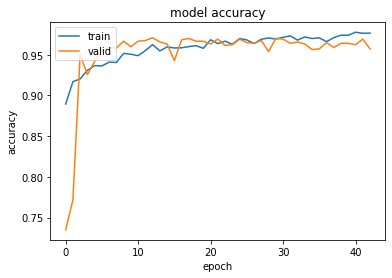

In [46]:
plt.plot(modelo_final_1_Hist.history['accuracy'])
plt.plot(modelo_final_1_Hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

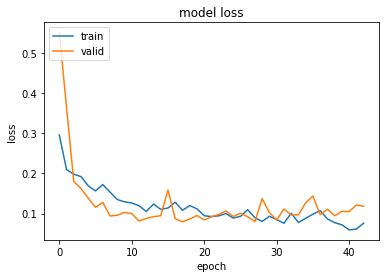

In [47]:
plt.plot(modelo_final_1_Hist.history['loss'])
plt.plot(modelo_final_1_Hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

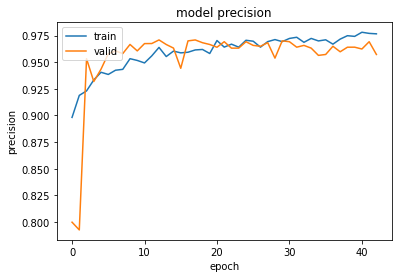

In [48]:
plt.plot(modelo_final_1_Hist.history['precision'])
plt.plot(modelo_final_1_Hist.history['val_precision'])
plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

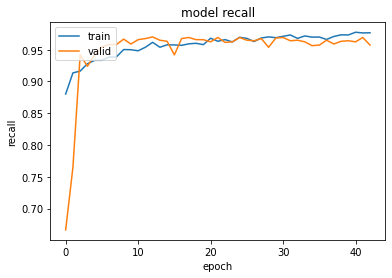

In [49]:
plt.plot(modelo_final_1_Hist.history['recall'])
plt.plot(modelo_final_1_Hist.history['val_recall'])
plt.title('model recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

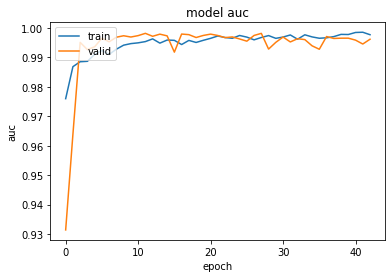

In [50]:
plt.plot(modelo_final_1_Hist.history['auc'])
plt.plot(modelo_final_1_Hist.history['val_auc'])
plt.title('model auc')
plt.ylabel('auc')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()